# This jupyter shows label = 日常章节考试 是否通过, LightGBM model train and evaluate results

In [1]:
import warnings
warnings.filterwarnings('ignore')
import time
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1. load data

In [2]:
data_ori = pd.read_csv('data/students_features_all.csv', encoding='utf_8_sig')
data_ori.head()

,file_name,student_name,student_type,course,course_order,chapter_number,chapter,chapter_order,is_final_exam,pass,...,last_5_notexam_pass_cnt,history_pass_cnt,history_notpass_cnt,last_5_exam_success_rate,history_exam_success_rate,score_improvement_over_last_5_exams,error_number_increase_over_history,last_5_total_exam_time,days_since_last_exam,total_exams_course
0,yb_9295081888william lindel_滞留中.xlsx,9295081888william lindel,滞留中,Anatomy – 解剖与机能,1,16.0,Anatomy – 解剖与机能 Chapter 1,1.0,0,未通过,...,NaN,0,1,NaN,0.00,0.79,-3.0,NaN,NaN,69
1,yb_9295081888william lindel_滞留中.xlsx,9295081888william lindel,滞留中,Anatomy – 解剖与机能,1,16.0,Anatomy – 解剖与机能 Chapter 1,1.0,0,通过,...,1.0,1,1,0.00,0.50,0.94,2.0,9.9,1.0,69
2,yb_9295081888william lindel_滞留中.xlsx,9295081888william lindel,滞留中,Anatomy – 解剖与机能,1,16.0,Anatomy – 解剖与机能 Chapter 1,1.0,0,通过,...,1.0,2,1,0.50,0.67,1.00,1.0,25.2,1.0,69
3,yb_9295081888william lindel_滞留中.xlsx,9295081888william lindel,滞留中,Anatomy – 解剖与机能,1,16.0,Anatomy – 解剖与机能 Chapter 1,1.0,0,未通过,...,1.0,2,2,0.67,0.50,0.88,-2.0,40.4,1.0,69
4,yb_9295081888william lindel_滞留中.xlsx,9295081888william lindel,滞留中,Anatomy – 解剖与机能,1,16.0,Anatomy – 解剖与机能 Chapter 1,1.0,0,通过,...,2.0,3,2,0.50,0.60,0.94,1.0,47.1,0.0,69


In [3]:
data_ori.shape

(410032, 74)

In [4]:
data_ori['student_type'].value_counts()

student_type
滞留中     198175
考过生     140806
在学生      67676
考试学员      3375
Name: count, dtype: int64

In [5]:
len(set(data_ori[data_ori['student_type']=='滞留中']['student_name']))

385

In [6]:
len(set(data_ori[data_ori['student_type']=='考过生']['student_name']))

163

In [7]:
len(set(data_ori[data_ori['student_type']=='在学生']['student_name']))

102

In [8]:
len(set(data_ori[data_ori['student_type']=='考试学员']['student_name']))

3

# 2. feature selection

In [9]:
not_fea = [
    'file_name',
    'student_name',
    
    'course',
    'chapter',

    'exam_type_name',
    'correct_number',
    'error_number',
    'score',
    'exam_time_minutes',
    'exam_date',
    'hour',

    'license_exam_date',
    'license_exam_pass',
    'notes',
]

label_columns = [
    'student_type',
    'pass',
    'student_type_stop',
    'student_type_pass',
    'student_type_learning',
    'student_type_exam',
    'pass_label',
]


features = [
    # 'file_name',
    #  'student_name',
    #  'student_type',
    # 'course',
    'course_order',
    'chapter_number',
    # 'chapter',
    'chapter_order',
    'is_final_exam',
    # 'pass',
    # 'student_type_stop',
    # 'student_type_pass',
    # 'student_type_learning',
    # 'student_type_exam',
    # 'pass_label',
    'exam_type',
    # 'exam_type_name',
    'items_number',
    # 'correct_number',
    # 'error_number',
    # 'score',
    # 'exam_time_minutes',
    # 'exam_date',
    'year',
    'month',
    'day',
    # 'hour',
    # 'license_exam_date',
    # 'license_exam_pass',
    # 'notes',
    'last_5_score_sum',
    'last_5_score_avg',
    'last_5_score_max',
    'last_5_score_min',
    'history_score_sum',
    'history_score_avg',
    'history_score_max',
    'history_score_min',
    'exam_times',
    'last_5_correct_number_sum',
    'last_5_correct_number_avg',
    'last_5_correct_number_max',
    'last_5_correct_number_min',
    'history_correct_number_sum',
    'history_correct_number_avg',
    'history_correct_number_max',
    'history_correct_number_min',
    'last_5_error_number_sum',
    'last_5_error_number_avg',
    'last_5_error_number_max',
    'last_5_error_number_min',
    'history_error_number_sum',
    'history_error_number_avg',
    'history_error_number_max',
    'history_error_number_min',
    'last_5_exam_time_minutes_sum',
    'last_5_exam_time_minutes_avg',
    'last_5_exam_time_minutes_max',
    'last_5_exam_time_minutes_min',
    'history_exam_time_minutes_avg',
    'history_exam_time_minutes_max',
    'history_exam_time_minutes_min',
    'last_5_exam_pass_cnt',
    'last_5_notexam_pass_cnt',
    'history_pass_cnt',
    'history_notpass_cnt',
    'last_5_exam_success_rate',
    'history_exam_success_rate',
    'score_improvement_over_last_5_exams',
    'error_number_increase_over_history',
    'last_5_total_exam_time',
    'days_since_last_exam',
    'total_exams_course',
]

In [10]:
len(not_fea+label_columns+features)

73

In [11]:
data_ori[not_fea].head()

,file_name,student_name,course,chapter,exam_type_name,correct_number,error_number,score,exam_time_minutes,exam_date,hour,license_exam_date,license_exam_pass,notes
0,yb_9295081888william lindel_滞留中.xlsx,9295081888william lindel,Anatomy – 解剖与机能,Anatomy – 解剖与机能 Chapter 1,关键词测试（中英）,11,3,0.79,9.9,2021-06-10 15:37:00,15,NaN,NaN,"续费两个月没有学,暂停"
1,yb_9295081888william lindel_滞留中.xlsx,9295081888william lindel,Anatomy – 解剖与机能,Anatomy – 解剖与机能 Chapter 1,关键词测试（英）,16,1,0.94,15.3,2021-06-11 11:58:00,11,NaN,NaN,NaN
2,yb_9295081888william lindel_滞留中.xlsx,9295081888william lindel,Anatomy – 解剖与机能,Anatomy – 解剖与机能 Chapter 1,关键词测试（英）,17,0,1.00,15.2,2021-06-12 03:27:00,3,NaN,NaN,NaN
3,yb_9295081888william lindel_滞留中.xlsx,9295081888william lindel,Anatomy – 解剖与机能,Anatomy – 解剖与机能 Chapter 1,关键词测试（英）,15,2,0.88,6.7,2021-06-13 03:03:00,3,NaN,NaN,NaN
4,yb_9295081888william lindel_滞留中.xlsx,9295081888william lindel,Anatomy – 解剖与机能,Anatomy – 解剖与机能 Chapter 1,关键词测试（英）,16,1,0.94,6.0,2021-06-13 03:09:00,3,NaN,NaN,NaN


In [12]:
data_ori[label_columns].head()

,student_type,pass,student_type_stop,student_type_pass,student_type_learning,student_type_exam,pass_label
0,滞留中,未通过,1,0,0,0,0
1,滞留中,通过,1,0,0,0,1
2,滞留中,通过,1,0,0,0,1
3,滞留中,未通过,1,0,0,0,0
4,滞留中,通过,1,0,0,0,1


In [13]:
data_ori[features].head()

,course_order,chapter_number,chapter_order,is_final_exam,exam_type,items_number,year,month,day,last_5_score_sum,...,last_5_notexam_pass_cnt,history_pass_cnt,history_notpass_cnt,last_5_exam_success_rate,history_exam_success_rate,score_improvement_over_last_5_exams,error_number_increase_over_history,last_5_total_exam_time,days_since_last_exam,total_exams_course
0,1,16.0,1.0,0,1,14,2021,6,10,NaN,...,NaN,0,1,NaN,0.00,0.79,-3.0,NaN,NaN,69
1,1,16.0,1.0,0,2,17,2021,6,11,0.79,...,1.0,1,1,0.00,0.50,0.94,2.0,9.9,1.0,69
2,1,16.0,1.0,0,2,17,2021,6,12,1.73,...,1.0,2,1,0.50,0.67,1.00,1.0,25.2,1.0,69
3,1,16.0,1.0,0,2,17,2021,6,13,2.73,...,1.0,2,2,0.67,0.50,0.88,-2.0,40.4,1.0,69
4,1,16.0,1.0,0,2,17,2021,6,13,3.61,...,2.0,3,2,0.50,0.60,0.94,1.0,47.1,0.0,69


# 3. train test random split

In [14]:
data = data_ori.copy()
data.shape

(410032, 74)

In [15]:
train_data, test_data, y_train, y_test = train_test_split(data, data[label_columns],random_state=10, test_size=0.3,shuffle=True)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [16]:
label = ['pass_label']
X_train = train_data[features]
y_train = train_data[label]

X_test = test_data[features]
y_test = test_data[label]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(287022, 52)
(287022, 1)
(123010, 52)
(123010, 1)


In [17]:
y_train.value_counts()

pass_label
1             228277
0              58745
Name: count, dtype: int64

In [18]:
y_test.value_counts()

pass_label
1             97567
0             25443
Name: count, dtype: int64

### 3.1 feature process

In [19]:
def feature_process(df):
    df = df.fillna(0)
    return df

In [20]:
X_train = feature_process(X_train)
X_test = feature_process(X_test)

### 3.2 LightGBM model train

In [21]:
import lightgbm as lgb
from lightgbm.callback import early_stopping
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from joblib import dump
start = time.time()
print('lightgbm start training: ' + str(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

# lightgbm parameters
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': ['auc'],
        'num_leaves': 50,
        'learning_rate': 0.05,
        'max_depth':4,
        # 'n_jobs':10,
        # 'max_bin':300,
        'n_estimators':300,
        'random_state':0,
        # 'class_weight':'balanced'
    }

lgbm_model = lgb.LGBMClassifier(**params)
lgbm_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='binary_logloss',
    callbacks=[early_stopping(stopping_rounds=20, verbose=2)]
)
dump(lgbm_model, 'model.pkl')
end = time.time()
print('lightgbm end training: '+ str(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))
print('lightgbm time: ' + str(end - start) + ' s')



lightgbm start training: 2024-01-29 07:53:23
[LightGBM] [Info] Number of positive: 228277, number of negative: 58745
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 287022, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795329 -> initscore=1.357354
[LightGBM] [Info] Start training from score 1.357354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### 3.3 LightGBM model predict and evaluate

In [22]:
# y_pred 0 1
# y_score <1的概率得分，具体得分值
def evaluation(y_true, y_pred, y_score):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    f1score = f1_score(y_true, y_pred, average='binary')
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    print('Accuracy: ', round(acc, 6))
    print('Precision: ', round(pre, 6))
    print('Recall: ', round(recall, 6))
    print('AUC: ', round(auc, 6))
    print('F1_Score: ', round(f1score, 6))
    print('混淆矩阵: ', confusion_matrix(y_true, y_pred))
    print('TN: ', tn)
    print('FP: ', fp)
    print('FN: ', fn)
    print('TP: ', tp)


In [23]:
test_data['pred_score'] = lgbm_model.predict_proba(test_data[features])[:, 1]
th = 0.5
test_data['y_pred'] = 0
test_data.loc[test_data['pred_score']>=th, 'y_pred'] = 1
test_data.head()

,file_name,student_name,student_type,course,course_order,chapter_number,chapter,chapter_order,is_final_exam,pass,...,history_notpass_cnt,last_5_exam_success_rate,history_exam_success_rate,score_improvement_over_last_5_exams,error_number_increase_over_history,last_5_total_exam_time,days_since_last_exam,total_exams_course,pred_score,y_pred
0,yb_张学珍_考过生.xlsx,张学珍,考过生,Anatomy – 解剖与机能,1,16.0,Anatomy – 解剖与机能 Chapter 13,13.0,0,通过,...,182,0.8,0.80,0.00,0.0,9.3,0.0,764,0.987243,1
1,yb_Yanling Wang_滞留中.xlsx,Yanling Wang,滞留中,Anatomy – 解剖与机能,1,16.0,Anatomy – 解剖与机能 Chapter 5,5.0,0,通过,...,201,1.0,0.77,0.00,1.0,26.7,0.0,207,0.999888,1
2,yb_LIANGXUELIAN_考过生.xlsx,LIANGXUELIAN,考过生,Professional – 专业与道德,5,16.0,Professional – 专业与道德 Chapter 14,14.0,0,通过,...,196,1.0,0.76,0.00,0.0,8.3,0.0,143,0.999880,1
3,yb_Qiben Zhu_在学生.xlsx,Qiben Zhu,在学生,Assessment – 评估与治疗,2,14.0,Assessment – 评估与治疗 Chapter 7,7.0,0,未通过,...,468,1.0,0.68,-0.06,-2.0,20.4,0.0,641,0.016695,0
4,yb_Jingyihou_滞留中.xlsx,Jingyihou,滞留中,Anatomy – 解剖与机能,1,16.0,Anatomy – 解剖与机能 (Final),16.0,1,通过,...,39,1.0,0.62,-0.10,-9.0,13.6,0.0,168,0.359282,0


In [24]:
test_data['pass_label'].value_counts()

pass_label
1    97567
0    25443
Name: count, dtype: int64

In [25]:
print("lightgbm pass_label evaluation: \n")
evaluation(test_data['pass_label'], test_data["y_pred"], test_data["pred_score"])

lightgbm pass_label evaluation: 

Accuracy:  0.96858
Precision:  0.966179
Recall:  0.995224
AUC:  0.991701
F1_Score:  0.980486
混淆矩阵:  [[22044  3399]
 [  466 97101]]
TN:  22044
FP:  3399
FN:  466
TP:  97101


In [26]:
test_data['student_type_pass'].value_counts()

student_type_pass
0    80646
1    42364
Name: count, dtype: int64

In [27]:
print("lightgbm student_type_pass evaluation: \n")
evaluation(test_data['student_type_pass'], test_data["y_pred"], test_data["pred_score"])

lightgbm student_type_pass evaluation: 

Accuracy:  0.432436
Precision:  0.363423
Recall:  0.862147
AUC:  0.597603
F1_Score:  0.511311
混淆矩阵:  [[16670 63976]
 [ 5840 36524]]
TN:  16670
FP:  63976
FN:  5840
TP:  36524


In [28]:
test_data.columns.tolist()

['file_name',
 'student_name',
 'student_type',
 'course',
 'course_order',
 'chapter_number',
 'chapter',
 'chapter_order',
 'is_final_exam',
 'pass',
 'student_type_stop',
 'student_type_pass',
 'student_type_learning',
 'student_type_exam',
 'pass_label',
 'exam_type',
 'exam_type_name',
 'items_number',
 'correct_number',
 'error_number',
 'score',
 'exam_time_minutes',
 'exam_date',
 'year',
 'month',
 'day',
 'hour',
 'license_exam_date',
 'license_exam_pass',
 'notes',
 'last_5_score_sum',
 'last_5_score_avg',
 'last_5_score_max',
 'last_5_score_min',
 'history_score_sum',
 'history_score_avg',
 'history_score_max',
 'history_score_min',
 'exam_times',
 'last_5_correct_number_sum',
 'last_5_correct_number_avg',
 'last_5_correct_number_max',
 'last_5_correct_number_min',
 'history_correct_number_sum',
 'history_correct_number_avg',
 'history_correct_number_max',
 'history_correct_number_min',
 'last_5_error_number_sum',
 'last_5_error_number_avg',
 'last_5_error_number_max',
 'la

In [29]:
d = test_data[['student_name','student_type','pass','pass_label','student_type_pass','y_pred','pred_score']]
d.head()

,student_name,student_type,pass,pass_label,student_type_pass,y_pred,pred_score
0,张学珍,考过生,通过,1,1,1,0.987243
1,Yanling Wang,滞留中,通过,1,0,1,0.999888
2,LIANGXUELIAN,考过生,通过,1,1,1,0.999880
3,Qiben Zhu,在学生,未通过,0,0,0,0.016695
4,Jingyihou,滞留中,通过,1,0,0,0.359282


In [30]:
d1 = d.groupby(['student_name','student_type'])['pass_label'].apply(list).reset_index()
d1['list_len'] = d1['pass_label'].apply(len)
d1['pass_label_avg'] = d1['pass_label'].apply(lambda x: sum(x)/len(x) if x else 0)
d1.head()

,student_name,student_type,pass_label,list_len,pass_label_avg
0,9295081888william lindel,滞留中,"[0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, ...",131,0.809160
1,9786477888,滞留中,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, ...",165,0.781818
2,A Ni sun,在学生,"[0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, ...",89,0.415730
3,Ada chen,滞留中,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",49,0.897959
4,Ai Dongmei,滞留中,"[1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, ...",86,0.744186


In [31]:
d2 = d.groupby(['student_name','student_type'])['y_pred'].apply(list).reset_index()
# d2['y_pred_len'] = d2['y_pred'].apply(len)
d2['y_pred_avg'] = d2['y_pred'].apply(lambda x: sum(x)/len(x) if x else 0)
d2.head()

,student_name,student_type,y_pred,y_pred_avg
0,9295081888william lindel,滞留中,"[0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, ...",0.816794
1,9786477888,滞留中,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, ...",0.793939
2,A Ni sun,在学生,"[0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, ...",0.471910
3,Ada chen,滞留中,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.897959
4,Ai Dongmei,滞留中,"[1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, ...",0.779070


In [32]:
d3 = d.groupby(['student_name','student_type', 'student_type_pass'])['pred_score'].apply(list).reset_index()
# d3['pred_score_len'] = d3['pred_score'].apply(len)
d3['pred_score_avg'] = d3['pred_score'].apply(lambda x: sum(x)/len(x) if x else 0)
th=0.5
d3['pred_score_label']=d3['pred_score_avg'].apply(lambda x: 1 if x>=th else 0)
d3.head()

,student_name,student_type,student_type_pass,pred_score,pred_score_avg,pred_score_label
0,9295081888william lindel,滞留中,0,"[0.0029170000751118008, 0.9998823935333762, 0....",0.789692,1
1,9786477888,滞留中,0,"[0.9997634979972014, 0.9998937611668381, 0.993...",0.758638,1
2,A Ni sun,在学生,0,"[0.2692756945429739, 0.020999773046064225, 0.8...",0.433193,0
3,Ada chen,滞留中,0,"[0.0001561659501516143, 0.6865074000236642, 0....",0.889338,1
4,Ai Dongmei,滞留中,0,"[0.9050711403021741, 0.9895411987982248, 6.546...",0.752542,1


In [33]:
d3.columns

Index(['student_name', 'student_type', 'student_type_pass', 'pred_score',
       'pred_score_avg', 'pred_score_label'],
      dtype='object')

In [34]:
d3['student_type'].value_counts()

student_type
滞留中     376
考过生     163
在学生     101
考试学员      3
Name: count, dtype: int64

In [35]:
d3.shape[0]

643

In [36]:
643-163

480

In [37]:
evaluation(d3['student_type_pass'], d3["pred_score_label"], d3["pred_score_avg"])

Accuracy:  0.342146
Precision:  0.278157
Recall:  1.0
AUC:  0.713292
F1_Score:  0.435247
混淆矩阵:  [[ 57 423]
 [  0 163]]
TN:  57
FP:  423
FN:  0
TP:  163


In [38]:
test_data['student_type_learning'].value_counts()

student_type_learning
0    102892
1     20118
Name: count, dtype: int64

In [39]:
print("lightgbm student_type_learning evaluation: \n")
evaluation(test_data['student_type_learning'], test_data["y_pred"], test_data["pred_score"])

lightgbm student_type_learning evaluation: 

Accuracy:  0.279213
Precision:  0.158975
Recall:  0.794164
AUC:  0.448671
F1_Score:  0.264919
混淆矩阵:  [[18369 84523]
 [ 4141 15977]]
TN:  18369
FP:  84523
FN:  4141
TP:  15977


### 3.4 lightgbm feature importance

In [72]:
lgb_important_fea = pd.DataFrame({
    "column": lgbm_model.feature_name_,
    "lgb_important_score": lgbm_model.feature_importances_
})
lgb_important_fea = lgb_important_fea.sort_values(by="lgb_important_score",ascending=False).reset_index(drop=True)
lgb_important_fea

,column,lgb_important_score
0,score_improvement_over_last_5_exams,741
1,items_number,669
2,error_number_increase_over_history,653
3,last_5_score_sum,243
4,course_order,215
5,last_5_error_number_max,196
6,last_5_score_min,169
7,last_5_score_max,131
8,history_exam_success_rate,118
9,last_5_exam_pass_cnt,89


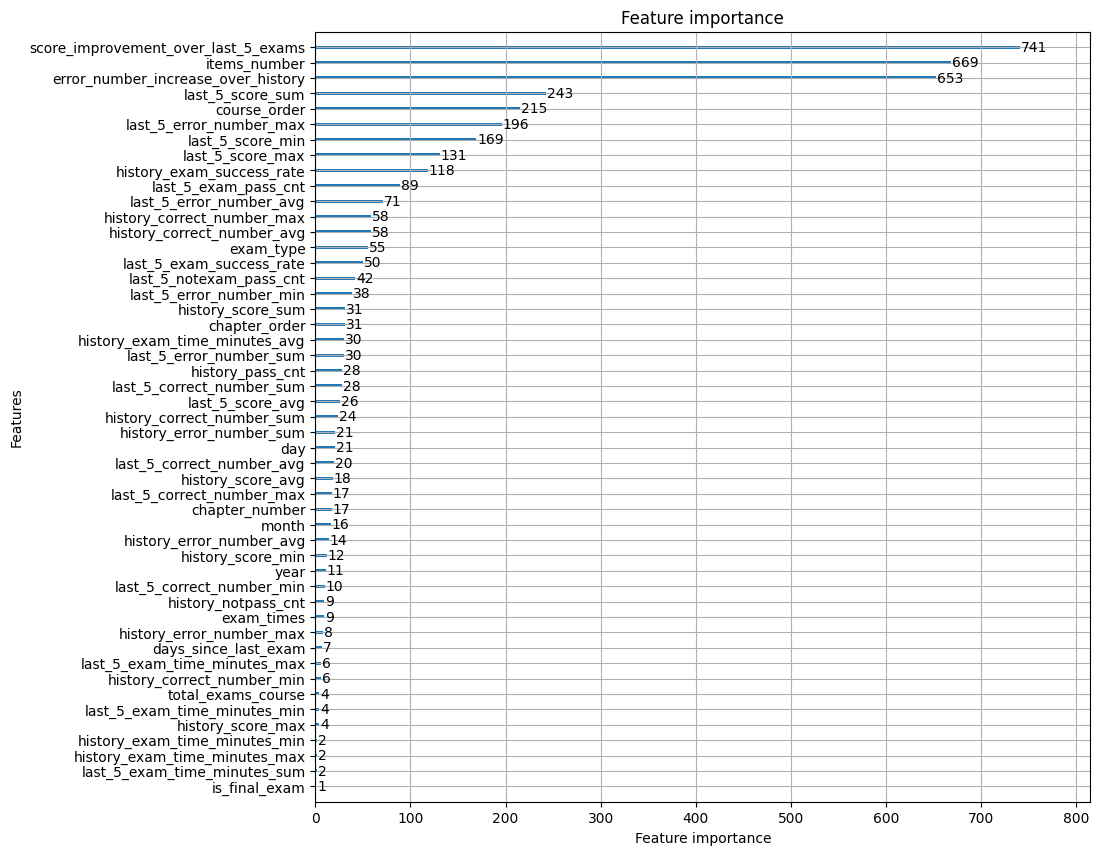

In [73]:
lgb.plot_importance(lgbm_model, figsize=(10, 10))
plt.show()

# 4. train test split by students

In [74]:
data = data_ori.copy()
data.shape

(410032, 74)

In [75]:
data.head(2)

,file_name,student_name,student_type,course,course_order,chapter_number,chapter,chapter_order,is_final_exam,pass,...,last_5_notexam_pass_cnt,history_pass_cnt,history_notpass_cnt,last_5_exam_success_rate,history_exam_success_rate,score_improvement_over_last_5_exams,error_number_increase_over_history,last_5_total_exam_time,days_since_last_exam,total_exams_course
0,yb_9295081888william lindel_滞留中.xlsx,9295081888william lindel,滞留中,Anatomy – 解剖与机能,1,16.0,Anatomy – 解剖与机能 Chapter 1,1.0,0,未通过,...,NaN,0,1,NaN,0.0,0.79,-3.0,NaN,NaN,69
1,yb_9295081888william lindel_滞留中.xlsx,9295081888william lindel,滞留中,Anatomy – 解剖与机能,1,16.0,Anatomy – 解剖与机能 Chapter 1,1.0,0,通过,...,1.0,1,1,0.0,0.5,0.94,2.0,9.9,1.0,69


In [76]:
student_name_all = data[['student_name']].drop_duplicates().reset_index(drop=True)
print(student_name_all.shape)
student_name_all.head()

(653, 1)


,student_name
0,9295081888william lindel
1,9786477888
2,A Ni sun
3,Ada chen
4,Ai Dongmei


In [77]:
train_students = student_name_all.sample(n=int(student_name_all.shape[0]*0.7), random_state=0)["student_name"].tolist()
print(len(train_students))
train_students[: 10]

457


['yujun deng',
 'miaoling pangelinan',
 'Angela',
 'OUCHUNYING',
 'Guangyao Zheng',
 'Jiao Peng',
 '张金梅',
 'yangguofang',
 'WuMinjie',
 'liu yuying']

In [78]:
test_students = [col for col in student_name_all["student_name"].tolist() if col not in train_students]
print(len(test_students))
test_students[: 10]

196


['Alice HU',
 'Amy0618',
 'Baowen Guo',
 'Bo guan',
 'CHUNXIA',
 'Cai Hongli',
 'Candy J',
 'Chaixiaohua',
 'Changhong Wang',
 'Chen Jing jeany']

In [79]:
train_data = data[data['student_name'].isin(train_students)].reset_index(drop=True)
test_data = data[data['student_name'].isin(test_students)].reset_index(drop=True)

### 4.1 train, test analyse

In [80]:
train_data.shape

(270266, 74)

In [81]:
label_columns

['student_type',
 'pass',
 'student_type_stop',
 'student_type_pass',
 'student_type_learning',
 'student_type_exam',
 'pass_label']

In [82]:
for col in label_columns:
    print(train_data[col].value_counts())
    print('\n--------\n')

student_type
滞留中     125375
考过生      96862
在学生      45229
考试学员      2800
Name: count, dtype: int64

--------

pass
通过     212803
未通过     57463
Name: count, dtype: int64

--------

student_type_stop
0    144891
1    125375
Name: count, dtype: int64

--------

student_type_pass
0    173404
1     96862
Name: count, dtype: int64

--------

student_type_learning
0    225037
1     45229
Name: count, dtype: int64

--------

student_type_exam
0    267466
1      2800
Name: count, dtype: int64

--------

pass_label
1    212803
0     57463
Name: count, dtype: int64

--------



In [83]:
# train data 中考过生数量 112
train_data[['student_name','student_type']].drop_duplicates()['student_type'].value_counts()

student_type
滞留中     274
考过生     112
在学生      69
考试学员      2
Name: count, dtype: int64

In [84]:
test_data.shape

(139766, 74)

In [85]:
for col in label_columns:
    print(test_data[col].value_counts())
    print('\n--------\n')

student_type
滞留中     72800
考过生     43944
在学生     22447
考试学员      575
Name: count, dtype: int64

--------

pass
通过     113041
未通过     26725
Name: count, dtype: int64

--------

student_type_stop
1    72800
0    66966
Name: count, dtype: int64

--------

student_type_pass
0    95822
1    43944
Name: count, dtype: int64

--------

student_type_learning
0    117319
1     22447
Name: count, dtype: int64

--------

student_type_exam
0    139191
1       575
Name: count, dtype: int64

--------

pass_label
1    113041
0     26725
Name: count, dtype: int64

--------



In [86]:
# test data 中考过生数量 51
test_data[['student_name','student_type']].drop_duplicates()['student_type'].value_counts()

student_type
滞留中     111
考过生      51
在学生      33
考试学员      1
Name: count, dtype: int64

## 4.2 feature process

In [87]:
def feature_process(df):
    df = df.fillna(0)
    return df

In [88]:
label = ['pass_label']
X_train = train_data[features]
y_train = train_data[label]

X_test = test_data[features]
y_test = test_data[label]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(270266, 52)
(270266, 1)
(139766, 52)
(139766, 1)


In [89]:
X_train = feature_process(X_train)
X_test = feature_process(X_test)

## 4.3 LightGBM model train

In [90]:
start = time.time()
print('lightgbm start training: ' + str(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

# lightgbm parameters
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': ['auc'],
        'num_leaves': 50,
        'learning_rate': 0.05,
        'max_depth':4,
        # 'n_jobs':10,
        # 'max_bin':300,
        'n_estimators':300,
        'random_state':0,
        # 'class_weight':'balanced'
    }

lgbm_model = lgb.LGBMClassifier(**params)
lgbm_model.fit(
            X_train,
            y_train,
            # categorical_feature=categorical_columns,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            callbacks=[early_stopping(stopping_rounds=20, verbose=2)]
            )

end = time.time()
print('lightgbm end training: '+ str(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))
print('lightgbm time: ' + str(end - start) + ' s')

lightgbm start training: 2024-01-29 07:56:02
[LightGBM] [Info] Number of positive: 212803, number of negative: 57463
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7236
[LightGBM] [Info] Number of data points in the train set: 270266, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787384 -> initscore=1.309226
[LightGBM] [Info] Start training from score 1.309226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

## 4.4 LightGBM model predict and evaluate

In [91]:
# y_pred 0 1
# y_score <1的概率得分，具体得分值
def evaluation(y_true, y_pred, y_score):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    f1score = f1_score(y_true, y_pred, average='binary')
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    print('Accuracy: ', round(acc, 6))
    print('Precision: ', round(pre, 6))
    print('Recall: ', round(recall, 6))
    print('AUC: ', round(auc, 6))
    print('F1_Score: ', round(f1score, 6))
    print('混淆矩阵: ', confusion_matrix(y_true, y_pred))
    print('TN: ', tn)
    print('FP: ', fp)
    print('FN: ', fn)
    print('TP: ', tp)


In [92]:
test_data['pred_score'] = lgbm_model.predict_proba(test_data[features])[:, 1]
th = 0.5
test_data['y_pred'] = 0
test_data.loc[test_data['pred_score']>=th, 'y_pred'] = 1
test_data.head()

,file_name,student_name,student_type,course,course_order,chapter_number,chapter,chapter_order,is_final_exam,pass,...,history_notpass_cnt,last_5_exam_success_rate,history_exam_success_rate,score_improvement_over_last_5_exams,error_number_increase_over_history,last_5_total_exam_time,days_since_last_exam,total_exams_course,pred_score,y_pred
0,yb_Alice HU_考过生.xlsx,Alice HU,考过生,Anatomy – 解剖与机能,1,16.0,Anatomy – 解剖与机能 Chapter 1,1.0,0,未通过,...,1,NaN,0.00,0.79,-3.0,NaN,NaN,88,0.000056,0
1,yb_Alice HU_考过生.xlsx,Alice HU,考过生,Anatomy – 解剖与机能,1,16.0,Anatomy – 解剖与机能 Chapter 1,1.0,0,通过,...,1,0.00,0.50,0.93,2.0,8.9,0.0,88,0.983505,1
2,yb_Alice HU_考过生.xlsx,Alice HU,考过生,Anatomy – 解剖与机能,1,16.0,Anatomy – 解剖与机能 Chapter 1,1.0,0,通过,...,1,0.50,0.67,1.00,1.0,134.5,0.0,88,0.989401,1
3,yb_Alice HU_考过生.xlsx,Alice HU,考过生,Anatomy – 解剖与机能,1,16.0,Anatomy – 解剖与机能 Chapter 1,1.0,0,通过,...,1,0.67,0.75,0.93,-1.0,137.7,0.0,88,0.985107,1
4,yb_Alice HU_考过生.xlsx,Alice HU,考过生,Anatomy – 解剖与机能,1,16.0,Anatomy – 解剖与机能 Chapter 2,2.0,0,未通过,...,2,0.75,0.60,0.79,-2.0,140.8,1.0,88,0.005701,0


In [93]:
test_data['pass_label'].value_counts()

pass_label
1    113041
0     26725
Name: count, dtype: int64

In [94]:
print("lightgbm pass_label evaluation: \n")
evaluation(test_data['pass_label'], test_data["y_pred"], test_data["pred_score"])

lightgbm pass_label evaluation: 

Accuracy:  0.97108
Precision:  0.968825
Recall:  0.996302
AUC:  0.992752
F1_Score:  0.982372
混淆矩阵:  [[ 23101   3624]
 [   418 112623]]
TN:  23101
FP:  3624
FN:  418
TP:  112623


In [95]:
test_data['student_type_pass'].value_counts()

student_type_pass
0    95822
1    43944
Name: count, dtype: int64

In [96]:
print("lightgbm student_type_pass evaluation: \n")
evaluation(test_data['student_type_pass'], test_data["y_pred"], test_data["pred_score"])

lightgbm student_type_pass evaluation: 

Accuracy:  0.399704
Precision:  0.328138
Recall:  0.868037
AUC:  0.569605
F1_Score:  0.476244
混淆矩阵:  [[17720 78102]
 [ 5799 38145]]
TN:  17720
FP:  78102
FN:  5799
TP:  38145


In [97]:
d = test_data[['file_name','student_name','student_type','course','chapter','exam_date','pass','pass_label','student_type_pass','y_pred','pred_score']]
d.head()

,file_name,student_name,student_type,course,chapter,exam_date,pass,pass_label,student_type_pass,y_pred,pred_score
0,yb_Alice HU_考过生.xlsx,Alice HU,考过生,Anatomy – 解剖与机能,Anatomy – 解剖与机能 Chapter 1,2021-09-12 05:39:00,未通过,0,1,0,0.000056
1,yb_Alice HU_考过生.xlsx,Alice HU,考过生,Anatomy – 解剖与机能,Anatomy – 解剖与机能 Chapter 1,2021-09-12 07:44:00,通过,1,1,1,0.983505
2,yb_Alice HU_考过生.xlsx,Alice HU,考过生,Anatomy – 解剖与机能,Anatomy – 解剖与机能 Chapter 1,2021-09-12 07:51:00,通过,1,1,1,0.989401
3,yb_Alice HU_考过生.xlsx,Alice HU,考过生,Anatomy – 解剖与机能,Anatomy – 解剖与机能 Chapter 1,2021-09-12 07:54:00,通过,1,1,1,0.985107
4,yb_Alice HU_考过生.xlsx,Alice HU,考过生,Anatomy – 解剖与机能,Anatomy – 解剖与机能 Chapter 2,2021-09-13 04:22:00,未通过,0,1,0,0.005701


In [98]:
d.to_csv('1.csv',index=False)

In [99]:
d3 = d.groupby(['student_name','student_type', 'student_type_pass'])['pred_score'].apply(list).reset_index()
# d3['pred_score_len'] = d3['pred_score'].apply(len)
d3['pred_score_avg'] = d3['pred_score'].apply(lambda x: sum(x)/len(x) if x else 0)
th=0.7
d3['pred_score_label']=d3['pred_score_avg'].apply(lambda x: 1 if x>=th else 0)
d3.head()

,student_name,student_type,student_type_pass,pred_score,pred_score_avg,pred_score_label
0,Alice HU,考过生,1,"[5.580612484222526e-05, 0.9835054637029356, 0....",0.750288,1
1,Amy0618,考过生,1,"[0.9986508491056486, 0.9985793270807652, 0.999...",0.764076,1
2,Baowen Guo,滞留中,0,"[0.9986508491056486, 0.0012131878290627853, 0....",0.687486,0
3,Bo guan,考过生,1,"[0.9944716558838795, 0.03213642740567801, 0.04...",0.788081,1
4,CHUNXIA,滞留中,0,"[0.00016591539660895817, 0.009612760101362135,...",0.654165,0


In [100]:
d3['student_type'].value_counts()

student_type
滞留中     111
考过生      51
在学生      33
考试学员      1
Name: count, dtype: int64

In [101]:
evaluation(d3['student_type_pass'], d3["pred_score_label"], d3["pred_score_avg"])

Accuracy:  0.561224
Precision:  0.372263
Recall:  1.0
AUC:  0.774577
F1_Score:  0.542553
混淆矩阵:  [[59 86]
 [ 0 51]]
TN:  59
FP:  86
FN:  0
TP:  51


### 4.5 lightgbm feature importance

In [102]:
lgb_important_fea = pd.DataFrame({
    "column": lgbm_model.feature_name_,
    "lgb_important_score": lgbm_model.feature_importances_
})
lgb_important_fea = lgb_important_fea.sort_values(by="lgb_important_score",ascending=False).reset_index(drop=True)
lgb_important_fea

,column,lgb_important_score
0,score_improvement_over_last_5_exams,741
1,items_number,669
2,error_number_increase_over_history,653
3,last_5_score_sum,243
4,course_order,215
5,last_5_error_number_max,196
6,last_5_score_min,169
7,last_5_score_max,131
8,history_exam_success_rate,118
9,last_5_exam_pass_cnt,88


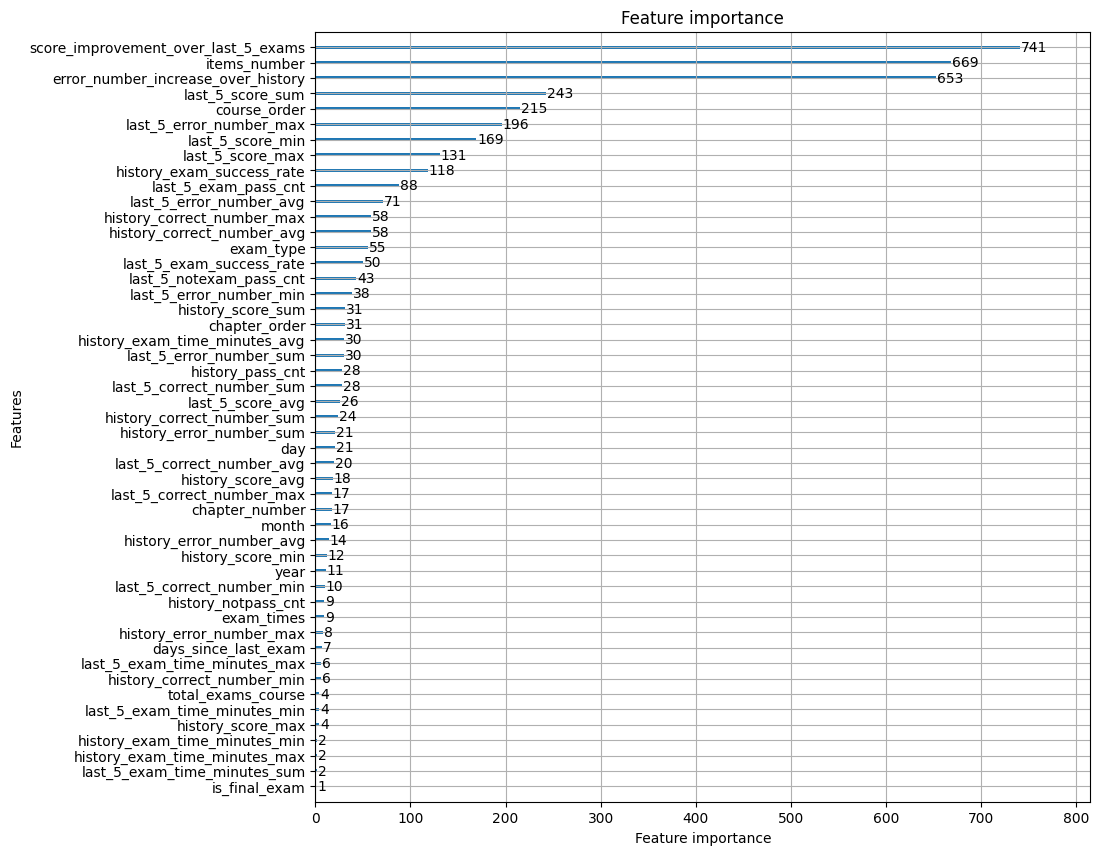

In [103]:
lgb.plot_importance(lgbm_model, figsize=(10, 10))
plt.savefig('lightgbm_feature_importance.png')
plt.show()